# Apartment Price Prediction in Kazakhstan

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

## Data Understanding

In [3]:
data = pd.read_csv("aptsdata.csv", sep='|')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86799 entries, 0 to 86798
Data columns (total 50 columns):
addedAt                86799 non-null object
agent                  86799 non-null int64
agent_id               86799 non-null int64
appliedPaidServices    63910 non-null object
balcony                60089 non-null object
balcony_g              44287 non-null object
bathroom               71449 non-null object
building_name          22691 non-null object
building_raw           86796 non-null object
building_type          0 non-null float64
categoryAlias          86799 non-null object
ceiling                0 non-null float64
city                   86543 non-null object
condition              77415 non-null object
corner_street          38120 non-null object
country                86799 non-null object
createdAt              86799 non-null object
description            83357 non-null object
district               55432 non-null object
door                   61530 non-null object

In [4]:
data.head()

,addedAt,agent,agent_id,appliedPaidServices,balcony,balcony_g,bathroom,building_name,building_raw,building_type,...,sectionAlias,security,sq,sq_k,sq_l,sq_raw,storage,street,title,year
0,2019-02-13,2,3175945,"Восстановить,В горячие предложения,Продлить,От...",NaN,NaN,раздельный,NaN,2019 г.п.,NaN,...,prodazha,NaN,NaN,NaN,NaN,39.14 м²,live,Turan,"1-комнатная квартира, 39.14 м², Туран — Улы Дала",NaN
1,2019-02-13,3,4742735,"Восстановить,В горячие предложения,Опубликоват...",NaN,NaN,NaN,Alatau City,"монолитный, 2018 г.п.",NaN,...,prodazha,NaN,NaN,NaN,NaN,45.1 м²,live,3-ya,"1-комнатная квартира, 45.1 м², 6/12 эт., 3-я 15",NaN
2,2019-02-13,2,8524982,"Отправить в «ТОП»,Выделить цветом,Отправить в ...",NaN,NaN,совмещенный,NaN,"панельный, 1980 г.п.",NaN,...,prodazha,"решетки на окнах, домофон",NaN,NaN,NaN,"32 м², жилая — 17 м², кухня — 6 м²",live,Buhar Zhyrau (Botanicheskiy),"1-комнатная квартира, 32 м², 1/5 эт., мкр Кокт...",NaN
3,2019-02-13,3,5420827,"Восстановить,В горячие предложения,Опубликоват...",NaN,NaN,NaN,NaN,2019 г.п.,NaN,...,prodazha,NaN,NaN,NaN,NaN,"36.1 м², кухня — 8 м²",live,Nazhimedenova,"1-комнатная квартира, 36.1 м², 8/10 эт., Нажим...",NaN
4,2019-02-13,2,8375156,Отправить в «ТОП»,NaN,NaN,NaN,Барселона (Barcelona),"монолитный, 2018 г.п.",NaN,...,prodazha,NaN,NaN,NaN,NaN,98 м²,live,A-34,"3-комнатная квартира, 98 м², 2/7 эт., A-34",NaN


In [5]:
data = data.dropna(axis=1, how='all')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86799 entries, 0 to 86798
Data columns (total 40 columns):
addedAt                86799 non-null object
agent                  86799 non-null int64
agent_id               86799 non-null int64
appliedPaidServices    63910 non-null object
balcony                60089 non-null object
balcony_g              44287 non-null object
bathroom               71449 non-null object
building_name          22691 non-null object
building_raw           86796 non-null object
categoryAlias          86799 non-null object
city                   86543 non-null object
condition              77415 non-null object
corner_street          38120 non-null object
country                86799 non-null object
createdAt              86799 non-null object
description            83357 non-null object
district               55432 non-null object
door                   61530 non-null object
exchange               13164 non-null object
floor_raw              85438 non-null 

## Data Cleaning and Formatting

Krisha.kz is mostly used by people in Kazakhstan, but allows users to post listings for any country. 

We're interested in apartments that are located in major cities of Kazakhstan. 

In [6]:
# Filtering major Kazakhstan cities
kz_cities = data[data['country'] == 'Kazahstan']
major_cities_counts = kz_cities['city'].value_counts()
major_cities = major_cities_counts[major_cities_counts > 100].index
data = data[data['city'].isin(major_cities)]

In [7]:
# Translating English names of the cities to Russian 
city_names = {
    'Almaty': 'Алматы',
    'Astana': 'Астана',
    'Aktau': 'Актау',
    'Karaganda': 'Караганда',
    'Aktobe': 'Актобе',
    'Shymkent': 'Шымкент',
    'Usty-Kamenogorsk': 'Усть-Каменогорск',
    'Pavlodar': 'Павлодар',
    'Taraz': 'Тараз',
    'Semey': 'Семей',
    'Uralysk': 'Уральск',
    'Atyrau': 'Атырау',
    'Kostanay': 'Костанай',
    'Kokshetau': 'Кокшетау',
    'Taldykorgan': 'Талдыкорган',
    'Kyzylorda': 'Кызылорда',
    'Petropavlovsk': 'Петропавловск',
    'Temirtau': 'Темиртау',
    'ekibastuz': 'Экибастуз',
    'Zhezkazgan': 'Жезказган',
    'Rudnyy': 'Рудный',
    'Zhanaozen': 'Жанаозен',
    'Kapchagay': 'Капчагай',
    'Kosshy': 'Косшы',
    'Shtuchinsk': 'Щучинск',
    'Talgar': 'Талгар',
    'Boralday': 'Боралдай',
    'Aksay': 'Аксай',
    'Aksu': 'Аксу',
    'Otegen batyr': 'Отеген Батыр',
    'Satpaev': 'Сатпаев',
    'Kaskelen': 'Каскелен',
    'Balhash': 'Балхаш',
}
data['city'] = data['city'].map(city_names)

In [8]:
# Rough bbox coordinates taken from Google Maps
rough_city_bbox = {
    'Алматы': {
        'min_lat': 43,
        'max_lat': 43.4,
        'min_lon': 76.75,
        'max_lon': 77.1
    },
    'Астана': {
        'min_lat': 51,
        'max_lat': 51.29,
        'min_lon': 71.2,
        'max_lon': 71.7
    },
    'Актау': {
        'min_lat': 43.57,
        'max_lat': 43.74,
        'min_lon': 51.14,
        'max_lon': 51.33
    },
    'Караганда': {
        'min_lat': 49.6,
        'max_lat': 49.97,
        'min_lon': 72.9,
        'max_lon': 73.24
    },
    'Актобе': {
        'min_lat': 50.18,
        'max_lat': 50.36,
        'min_lon': 57,
        'max_lon': 57.3
    },
    'Шымкент': {
        'min_lat': 42.27,
        'max_lat': 42.4,
        'min_lon': 69.45,
        'max_lon': 69.72
    },
    'Усть-Каменогорск': {
        'min_lat': 49.87,
        'max_lat': 50,
        'min_lon': 82.46,
        'max_lon': 82.72
    },
    'Павлодар': {
        'min_lat': 52.22,
        'max_lat': 52.40,
        'min_lon': 76.86,
        'max_lon': 77
    },
    'Тараз': {
        'min_lat': 42.83,
        'max_lat': 42.95,
        'min_lon': 71.26,
        'max_lon': 71.46
    },
    'Семей': {
        'min_lat': 50.34,
        'max_lat': 50.47,
        'min_lon': 80.15,
        'max_lon': 80.35
    },
    'Уральск': {
        'min_lat': 51.14,
        'max_lat': 51.28,
        'min_lon': 51.26,
        'max_lon': 51.5
    },
    'Атырау': {
        'min_lat': 47,
        'max_lat': 47.18,
        'min_lon': 51.82,
        'max_lon': 52
    },
    'Костанай': {
        'min_lat': 53.12,
        'max_lat': 53.27,
        'min_lon': 63.53,
        'max_lon': 63.69
    },
    'Кокшетау': {
        'min_lat': 53.25,
        'max_lat': 53.34,
        'min_lon': 69.35,
        'max_lon': 69.46
    },
    'Талдыкорган': {
        'min_lat': 44.96,
        'max_lat': 45.05,
        'min_lon': 78.35,
        'max_lon': 78.45
    },
    'Кызылорда': {
        'min_lat': 44.77,
        'max_lat': 44.88,
        'min_lon': 65.46,
        'max_lon': 65.57
    },
    'Петропавловск': {
        'min_lat': 54.81,
        'max_lat': 54.92,
        'min_lon': 69.08,
        'max_lon': 69.25
    },
    'Темиртау': {
        'min_lat': 50,
        'max_lat': 50.11,
        'min_lon': 72.87,
        'max_lon': 73
    },
    'Экибастуз': {
        'min_lat': 51.68,
        'max_lat': 51.76,
        'min_lon': 75.27,
        'max_lon': 75.36
    },
    'Жезказган': {
        'min_lat': 47.75,
        'max_lat': 47.82,
        'min_lon': 67.66,
        'max_lon': 67.76
    },
    'Рудный': {
        'min_lat': 52.95,
        'max_lat': 53,
        'min_lon': 63,
        'max_lon': 63.16
    },
    'Жанаозен': {
        'min_lat': 43.31,
        'max_lat': 43.38,
        'min_lon': 52.78,
        'max_lon': 52.94
    },
    'Капчагай': {
        'min_lat': 43.84,
        'max_lat': 43.89,
        'min_lon': 77,
        'max_lon': 77.1
    },
    'Косшы': {
        'min_lat': 50.95,
        'max_lat': 50.99,
        'min_lon': 71.33,
        'max_lon': 71.39
    },
    'Щучинск': {
        'min_lat': 52.89,
        'max_lat': 52.97,
        'min_lon': 70.13,
        'max_lon': 70.26
    },
    'Талгар': {
        'min_lat': 43.28,
        'max_lat': 43.34,
        'min_lon': 77.2,
        'max_lon': 77.25
    },
    'Боралдай': {
        'min_lat': 43.33,
        'max_lat': 43.38,
        'min_lon': 76.83,
        'max_lon': 76.89
    },
    'Аксай': {
        'min_lat': 51.14,
        'max_lat': 51.19,
        'min_lon': 52.96,
        'max_lon': 53
    },
    'Аксу': {
        'min_lat': 52,
        'max_lat': 52.15,
        'min_lon': 76.84,
        'max_lon': 76.96
    },
    'Отеген Батыр': {
        'min_lat': 43.39,
        'max_lat': 43.44,
        'min_lon': 76.99,
        'max_lon': 77.04
    },
    'Сатпаев': {
        'min_lat': 47.87,
        'max_lat': 47.91,
        'min_lon': 67.5,
        'max_lon': 67.57
    },
    'Каскелен': {
        'min_lat': 43.17,
        'max_lat': 43.22,
        'min_lon': 76.6,
        'max_lon': 76.65
    },
    'Балхаш': {
        'min_lat': 46.79,
        'max_lat': 46.90,
        'min_lon': 74.92,
        'max_lon': 75.05
    }
}


def impute_city_by_coords(df):
    cities = df['city'].value_counts().index
    for city in cities:
        min_lat = rough_city_bbox[city]['min_lat']
        max_lat = rough_city_bbox[city]['max_lat']
        min_lon = rough_city_bbox[city]['min_lon']
        max_lon = rough_city_bbox[city]['max_lon']

        df.loc[df['city'].isnull() & (df['lat'] >= min_lat) & (df['lat'] <= max_lat) & (df['lon'] >= min_lon) & (df['lon'] <= max_lon), 'city'] = city


impute_city_by_coords(data)

# Dropping entries with missing 'city' values
data = data.dropna(subset=['city'])

In [9]:
# Checking if all cities are specified 
data[data['city'].isnull()].shape

(0, 40)

In [10]:
# Translating the names of districts
district_names = {
    'Esilyskiy r-n': 'Есильский',
    'Bostandykskiy r-n': 'Бостандыкский',
    'Almatinskiy r-n': 'Алматинский',
    'Almalinskiy r-n': 'Алмалинкский',
    'Auezovskiy r-n': 'Ауезовский',
    'Medeuskiy r-n': 'Медеуский',
    'Saryarkinskiy r-n': 'Сарыаркинский',
    'Kazybek bi r-n': 'Казыбек Би',
    'r-n Baykonur': 'Байконур',
    'Zhetysuskiy r-n': 'Жетысуский',
    'Turksibskiy r-n': 'Турксибский',
    'Oktyabryskiy r-n': 'Октябрьский',
    'Alatauskiy r-n': 'Алатауский',
    'Aly-Farabiyskiy r-n': 'Аль-Фарабийский',
    'Nauryzbayskiy r-n': 'Наурызбайский',
    'Enbekshinskiy r-n': 'Енбекшинский',
    'Staryy gorod': 'Старый город',
    'Novyy gorod': 'Новый город',
    'Abayskiy r-n': 'Абайский',
    'Karatauskiy r-n': 'Каратауский',
    'mkr 5': 'Мкр. 5',
    'mkr 8': 'Мкр. 8',
    'mkr 11': 'Мкр. 11',
    'mkr 12': 'Мкр. 12',
    'Nur Aktobe': 'Нур Актобе',
}
data['district'] = data['district'].map(district_names)

In [11]:
data[data['district'].isnull()].shape

(28114, 40)

In [12]:
# Imputing districts by looking at the closest apartments using RadiusNeighborsClassifier
def impute_district_by_coords(df):
    x_columns = ['lat', 'lon']
    # The column that we want to predict
    y_column = ["district"]
    
    cities = df['city'].value_counts().index
    
    for city in cities:
        train = df[(df['city'] == city) & df['district'].notnull() & (df['lat'] >= rough_city_bbox[city]['min_lat']) & (df['lat'] <= rough_city_bbox[city]['max_lat']) & (df['lon'] >= rough_city_bbox[city]['min_lon']) & (df['lon'] <= rough_city_bbox[city]['max_lon'])]
        test = df[(df['city'] == city) & df['district'].isnull()]

        #print("city", city)
        #print('train', train.shape)
        #print('test', test.shape)
        
        # Making sure we have at least some training data
        if train.shape[0] > 0 and test.shape[0] > 0:
            from sklearn.neighbors import RadiusNeighborsClassifier
            # Create the rnc model
            # Look at the closest neighbors within the radius of 0.01
            rnc = RadiusNeighborsClassifier(radius=0.01, outlier_label='N/A')
            # Fit the model on the training data
            rnc.fit(train[x_columns], train[y_column])
            # Make point predictions on the test set using the fit model
            predictions = rnc.predict(test[x_columns])
            df.loc[(df['city'] == city) & df['district'].isnull(), 'district'] = predictions

In [13]:
impute_district_by_coords(data)

/Users/Kairat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/Kairat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/Kairat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/Kairat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/Kairat/anaconda3/lib/python3.6/site-packages/ipykernel_la

In [20]:
# removing rows with 'N/A' districts
data = data[data['district'] != 'N/A']
data[data['district'].isnull()].shape

(24420, 40)

In [21]:
# removing rows with unspecified condition of the apartment
data = data[data['condition'].notnull()]

In [22]:
def extract_room_count(s: str) -> str:
    items = s.split(",")
    if len(items) > 0:
        if(items[0] != ""):
            return int(items[0][0])
    else:
        return ""

data['room_count'] = data['title'].fillna("").apply(extract_room_count)

In [23]:
def extract_street(s: str) -> str:
    items = s.split(",")
    if len(items) > 1:
        if(items[len(items)-1] != ""):
            return items[len(items)-1]
    else:
        return ""

data['street'] = data['title'].fillna("").apply(extract_street)

In [24]:
def extract_level_count(s: str) -> str:
    items = s.split(",")
    if len(items) > 3:
        if(items[2] != ""):
            level_items = items[2].strip().split(" ")[0].split("/")
            if len(level_items) > 1:
                return level_items[1]
    return ""

def extract_level(s: str) -> str:
    items = s.split(",")
    if len(items) > 3:
        if(items[2] != ""):
            level_items = items[2].strip().split("/")
            if len(level_items) > 0 and level_items[0] != "" and level_items[0][0].isdigit():
                return level_items[0]
    return ""

# extracting level values
data['level_count'] = data['title'].fillna("").apply(extract_level_count)
data['level'] = data['title'].fillna("").apply(extract_level)

# setting missing values as 0
data.loc[data['level'] == "", 'level'] = 0
data.loc[data['level_count'] == "", 'level_count'] = 0

# changing incorrectly parsed values to 0
data.loc[data['level'].str.contains('мкр', na=False), 'level'] = 0

# extracting level for special cases
data.loc[data['level'].str.contains('эт', na=False), 'level'] = data.loc[data['level'].str.contains('эт', na=False), 'level'].apply(lambda x: x.split(" ")[0])

data[['level', 'level_count']] = data[['level', 'level_count']].astype('int64')
data[['level', 'level_count']].dtypes

# removing missing or wrong data
data = data[~((data['level'] > data['level_count']) & (data['level_count'] != 0))]
data = data[data['level_count'] != 0]
data = data[(data['level_count'] <= 40) & (data['level'] <= 40)]

In [25]:
def extract_area(s: str) -> str:
    items = s.split(" ")
    if len(items) > 1:
        return round(float(items[0]))
    return 0

data['area'] = data['sq_raw'].fillna("").apply(extract_area)

# Filtering out 'luxury' apartments that have huge areas and very small ones
data = data[(data['area'] <= 300) & (data['area'] >= 25)]

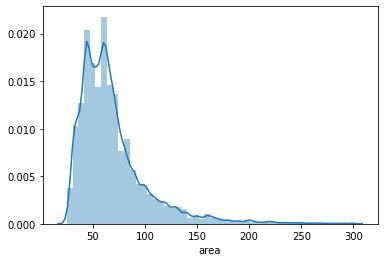

In [26]:
sns.distplot(data['area'])

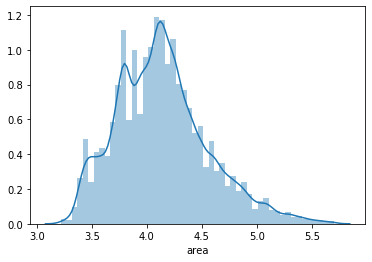

In [27]:
# Taking a log of area, since it is positively skewed.
data['area'] = np.log(data['area'])
sns.distplot(data['area'])

In [28]:
def extract_building_year(s: str) -> str:
    items = s.split(",")
    if len(items) == 2:
        return items[1].strip()[:4]
    elif len(items) == 1 and items[0] != "" and items[0][0].isdigit():
        return s[:4]
    else:
        return ""
    
data['building_year'] = data['building_raw'].fillna("").apply(extract_building_year)
data = data[data['building_year'] != ""]
data['building_year'] = data['building_year'].astype('int64');

In [29]:
def extract_building_type(s: str) -> str:
    items = s.split(",")
    if len(items) == 2:
        return items[0].strip()
    elif len(items) == 1 and items[0] != "" and items[0][0].isdigit():
        return np.NaN
    else:
        return s
    
data['building_type'] = data['building_raw'].fillna("").apply(extract_building_type)

In [30]:
# Imputing building type by looking at the 4 closest apartments using KNNClassifierPredictions
def impute_building_type(df):
    x_columns = ['level_count', 'building_year', 'lat', 'lon']
    # The column that we want to predict
    y_column = ["building_type"]
    
    cities_with_districts = df[df['district'].notnull()]['city'].value_counts().index
    cities_without_districts = df[df['district'].isnull()]['city'].value_counts().index
    
    for city in cities_with_districts:
        districts = df[df['city'] == city]['district'].value_counts().index
        
        for district in districts:
            train = df[(df['city'] == city) & (df['district'] == district) & df['building_type'].notnull()]
            test = df[(df['city'] == city) & (df['district'] == district) & df['building_type'].isnull()]
        
            # Making sure we have at least some training data
            if train.shape[0] > 0 and test.shape[0] > 0:
                knn_predictions = KNNClassifierPredictions(x_columns, y_column, train, test)
                df.loc[(df['city'] == city) & (df['district'] == district) & df['building_type'].isnull(), 'building_type'] = knn_predictions

    for city in cities_without_districts:
        train = df[(df['city'] == city) & df['building_type'].notnull()]
        test = df[(df['city'] == city) & df['building_type'].isnull()]

        # Making sure we have at least some training data
        if train.shape[0] > 0 and test.shape[0] > 0:
            knn_predictions = KNNClassifierPredictions(x_columns, y_column, train, test)
            df.loc[(df['city'] == city) & df['building_type'].isnull(), 'building_type'] = knn_predictions

def KNNClassifierPredictions(x_columns, y_column, train, test):
    from sklearn.neighbors import KNeighborsClassifier
    # Create the knc model
    # Look at the 5 closest apartments
    knc = KNeighborsClassifier(n_neighbors=4)
    # Fit the model on the training data
    knc.fit(train[x_columns], train[y_column])
    # Make point predictions on the test set using the fit model
    predictions = knc.predict(test[x_columns])
    return predictions

In [31]:
impute_building_type(data)

/Users/Kairat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/Kairat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/Kairat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/Kairat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/Kairat/anaconda3/lib/python3.6/site-packages/ipykernel_la

/Users/Kairat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/Kairat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/Kairat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/Kairat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/Kairat/anaconda3/lib/python3.6/site-packages/ipykernel_la

In [32]:
important_columns = [ 
    'city', 'room_count', 'area', 
    'building_year', 'building_type',
    'condition', 'mortgage',  
    'level', 'level_count', 'street', 'district',
    'price', 'title']
data = data[important_columns]

In [33]:
# Let's check what columns contain missing data.
for column in important_columns:
    print("Shape for column: ", column, data[data[column].isnull()].shape)
    if data[column].dtype == 'O':
        print('Empty string count:', data[(data[column] == "") | (data[column] == " ")].shape[0])
    elif data[column].dtype == 'int64':
        print('Zero value count:', data[data[column] == 0].shape[0])
    print('')

Shape for column:  city (0, 13)
Empty string count: 0

Shape for column:  room_count (0, 13)
Zero value count: 0

Shape for column:  area (0, 13)

Shape for column:  building_year (0, 13)
Zero value count: 0

Shape for column:  building_type (0, 13)
Empty string count: 0

Shape for column:  condition (0, 13)
Empty string count: 0

Shape for column:  mortgage (0, 13)
Zero value count: 68180

Shape for column:  level (0, 13)
Zero value count: 0

Shape for column:  level_count (0, 13)
Zero value count: 0

Shape for column:  street (0, 13)
Empty string count: 0

Shape for column:  district (21148, 13)
Empty string count: 0

Shape for column:  price (0, 13)
Zero value count: 0

Shape for column:  title (0, 13)
Empty string count: 0



Ignoring the zeros in mortgage, because in this case it indicates a False value.

Looks like none of the columns except "district" have missing data. There are small cities where no district is specified. So we're going to build our model on a **city-by-city basis**.

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71570 entries, 1 to 86797
Data columns (total 13 columns):
city             71570 non-null object
room_count       71570 non-null int64
area             71570 non-null float64
building_year    71570 non-null int64
building_type    71570 non-null object
condition        71570 non-null object
mortgage         71570 non-null int64
level            71570 non-null int64
level_count      71570 non-null int64
street           71570 non-null object
district         50422 non-null object
price            71570 non-null int64
title            71570 non-null object
dtypes: float64(1), int64(6), object(6)
memory usage: 7.6+ MB


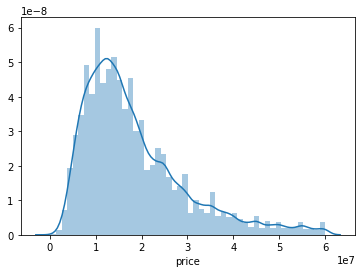

In [35]:
# Remove super expensive apartments and cap the price at 60,000,000 KZT,
# so we don't have to deal with the obvious outliers later on.
data = data[data['price'] <= 60000000]
sns.distplot(data['price'])

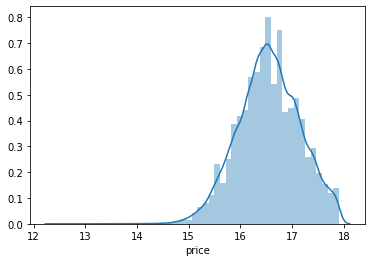

In [36]:
# Taking a log of price, since it is positively skewed
data['price'] = np.log(data['price'])
sns.distplot(data['price'])

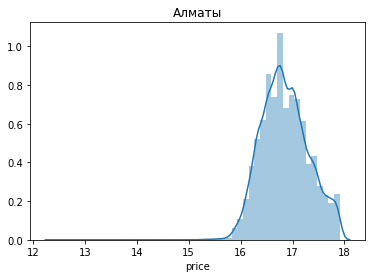

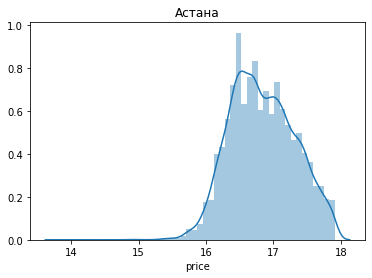

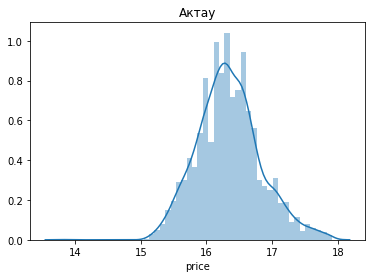

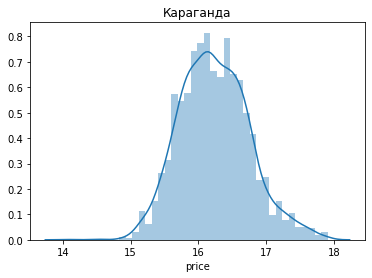

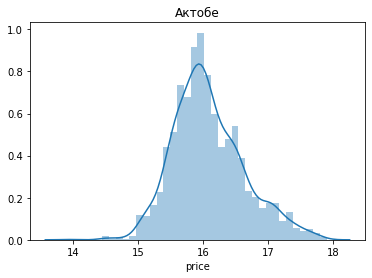

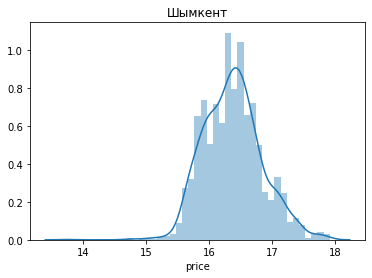

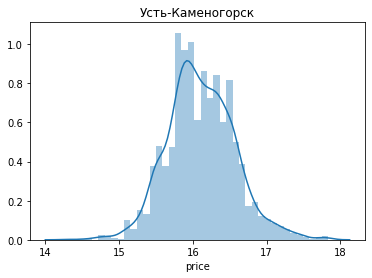

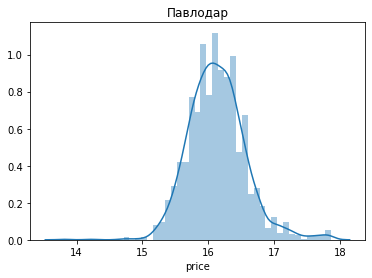

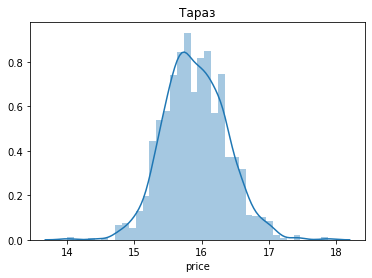

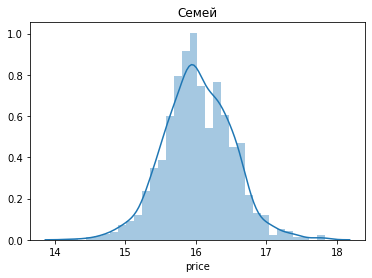

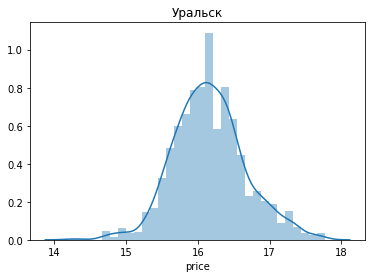

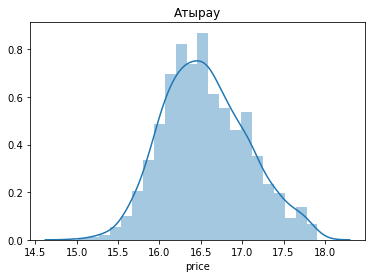

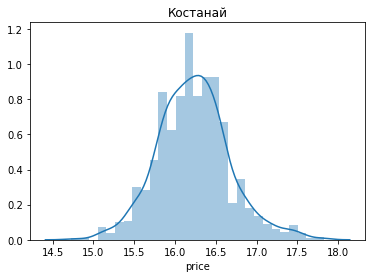

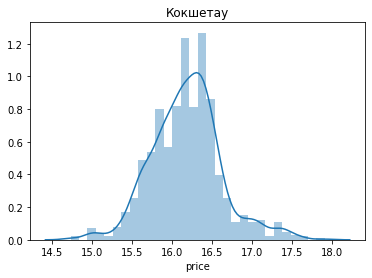

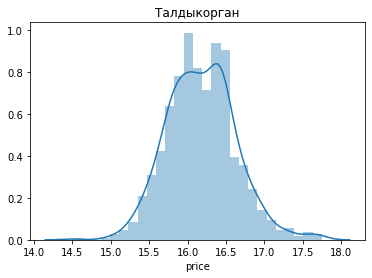

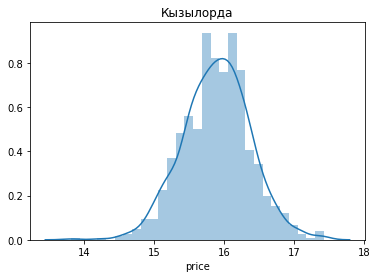

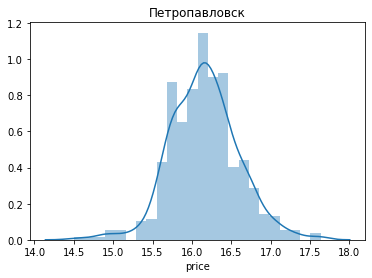

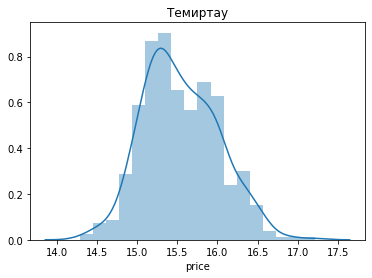

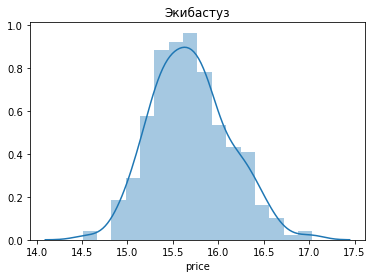

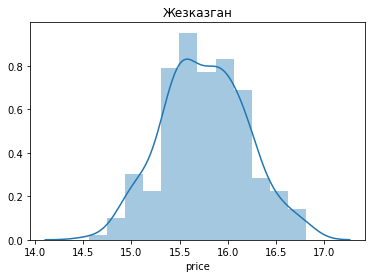

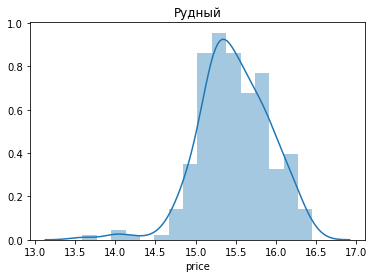

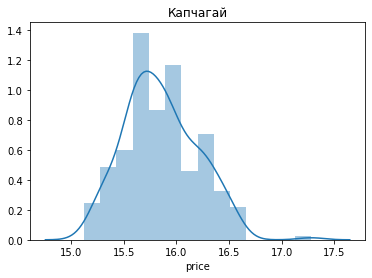

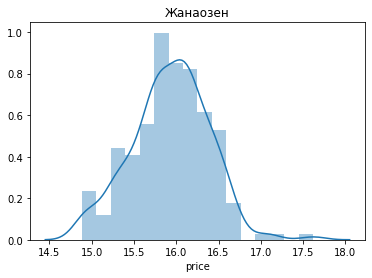

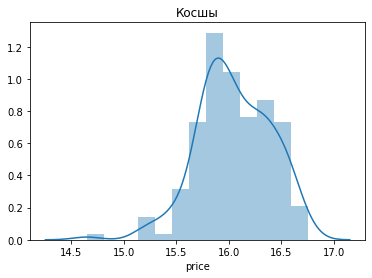

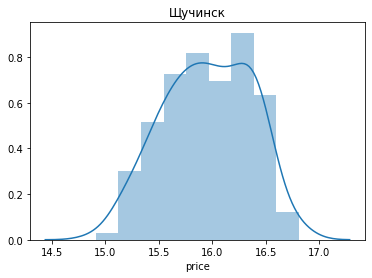

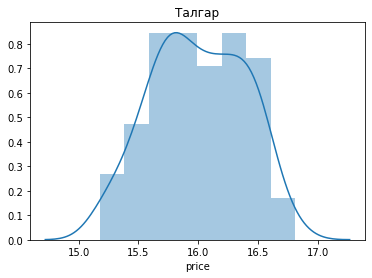

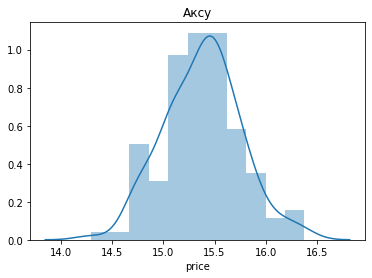

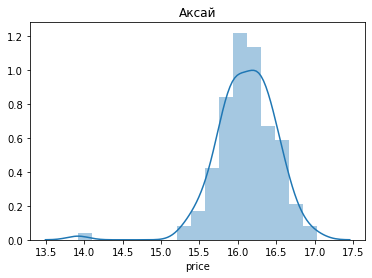

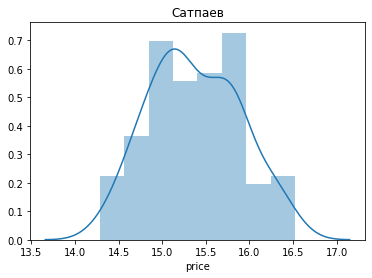

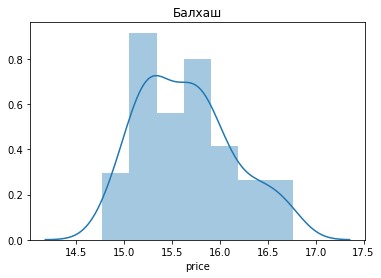

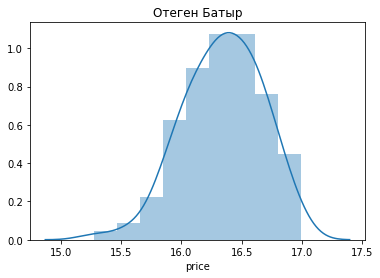

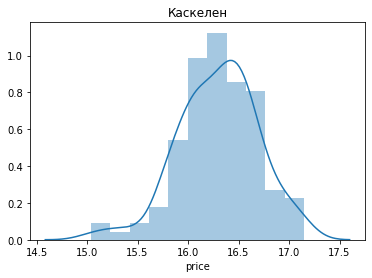

In [37]:
# Checking the price distribution for each major city.
cities = data['city'].value_counts().index
for i, city in enumerate(cities):
    city_data = data[data['city'] == city]
    plt.figure(i)
    plt.title(city)
    sns.distplot(city_data['price'])

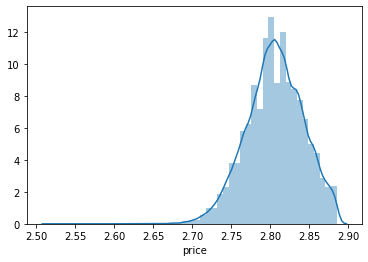

In [29]:
price = data[data['price'] <= 60000000]['price']
log_price = np.log(price)
sns.distplot(log_price)

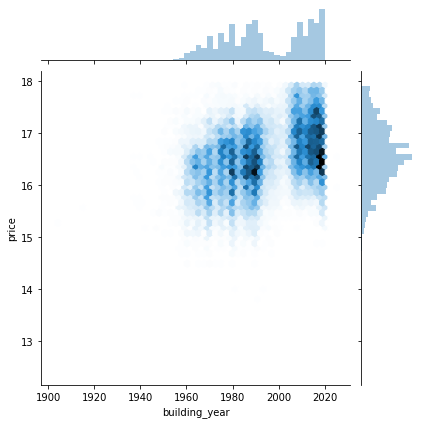

In [38]:
sns.jointplot(x='building_year', y='price', data=data, kind='hex')

There are two distinctive clusters of buildings: 
- Built in the USSR 
- Built in the years of independence

In [43]:
# Let's categorize the buildings by the year: 0 - built before 2000, 1 - built after 2000
data['building_new'] = data['building_year'].apply(lambda year: "1" if year >= 2000 else "0")

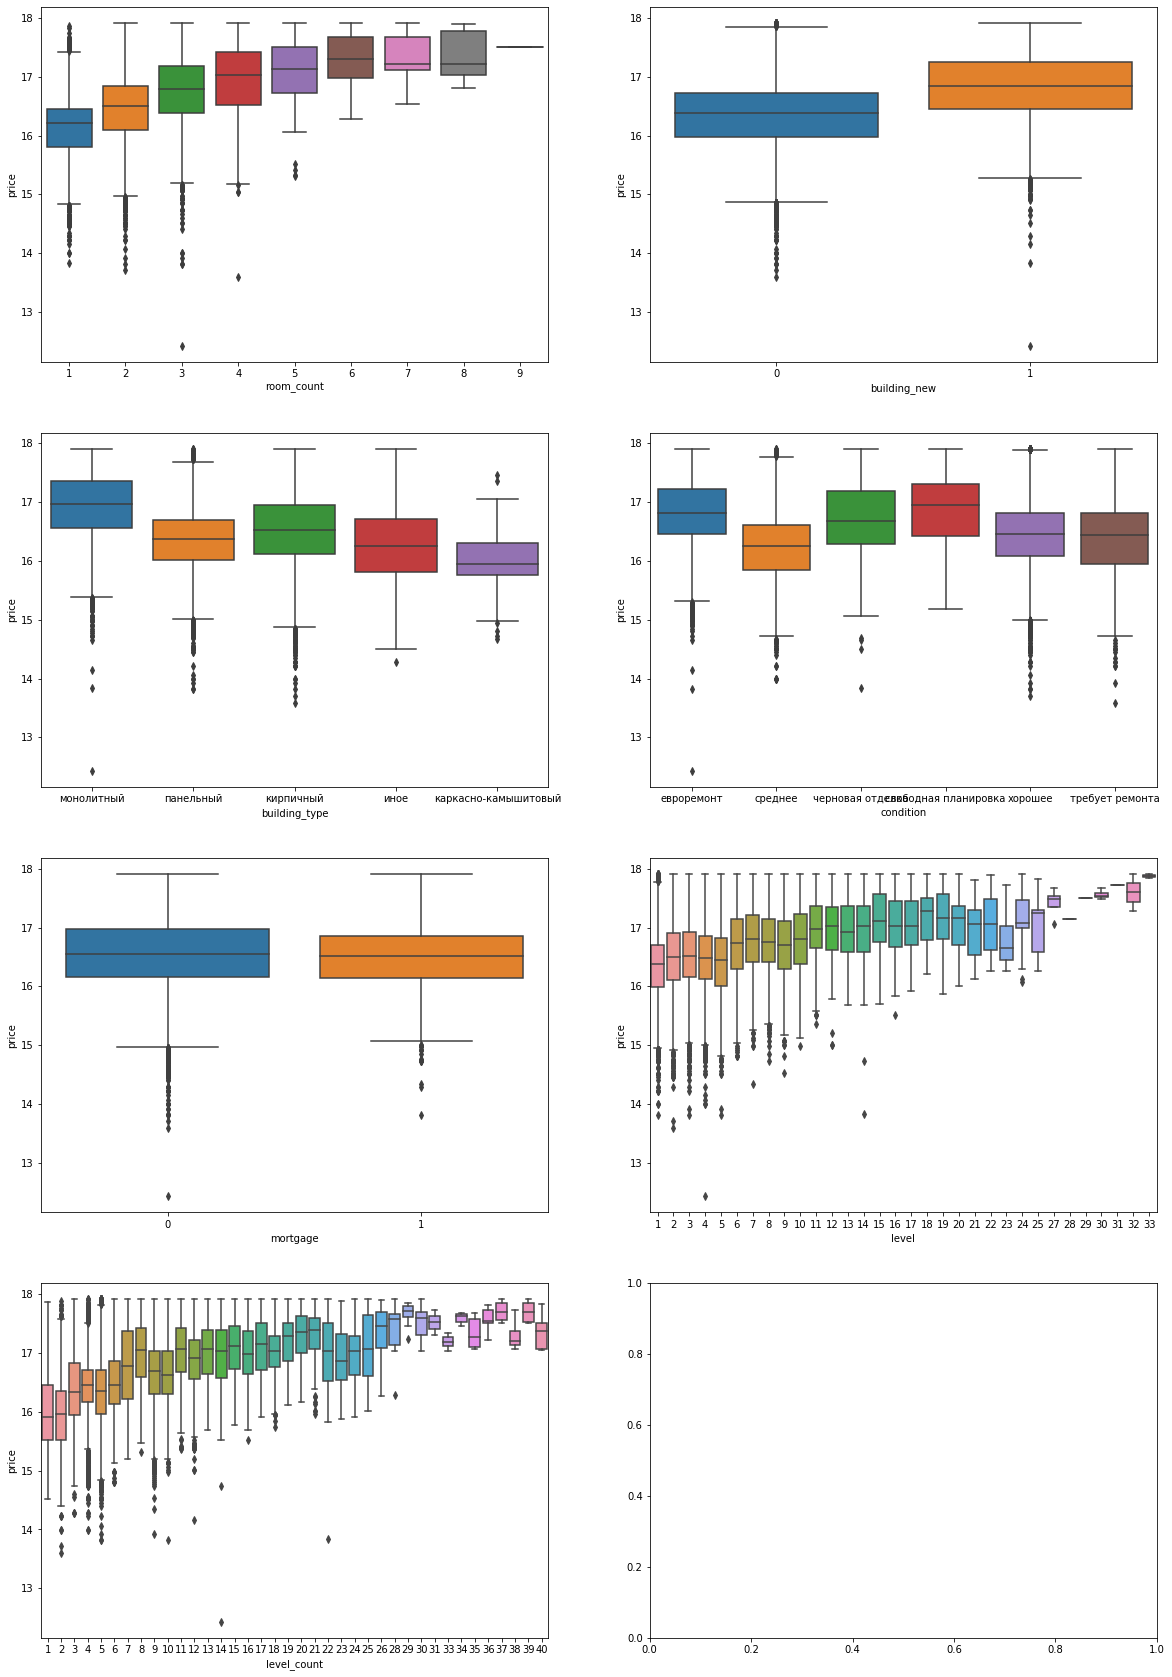

In [44]:
# Let's look at the relationships between price and different variables.
columns = ['room_count', 'building_new', 'building_type', 'condition', 
           'mortgage', 'level', 'level_count']
fig, ax = plt.subplots(4, 2, figsize=(20,30))
for i, col in enumerate(columns):
    sns.boxplot(x=col, y='price', data=data, ax=ax[i//2][i%2])

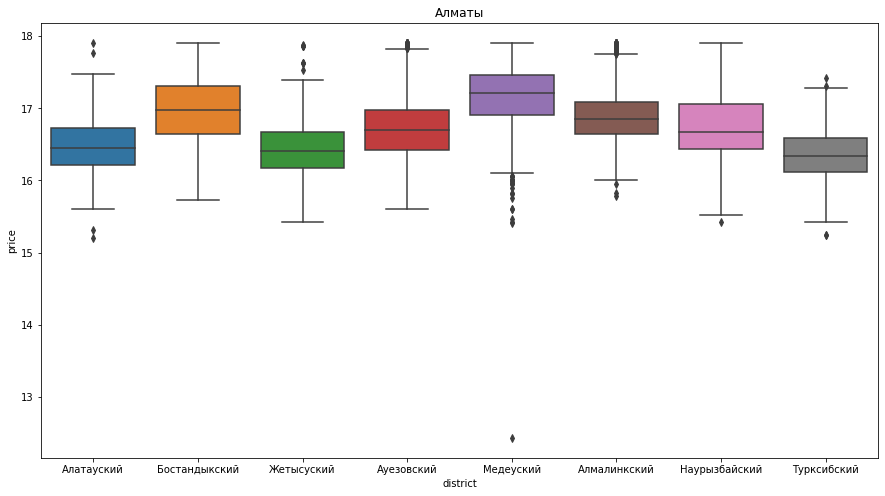

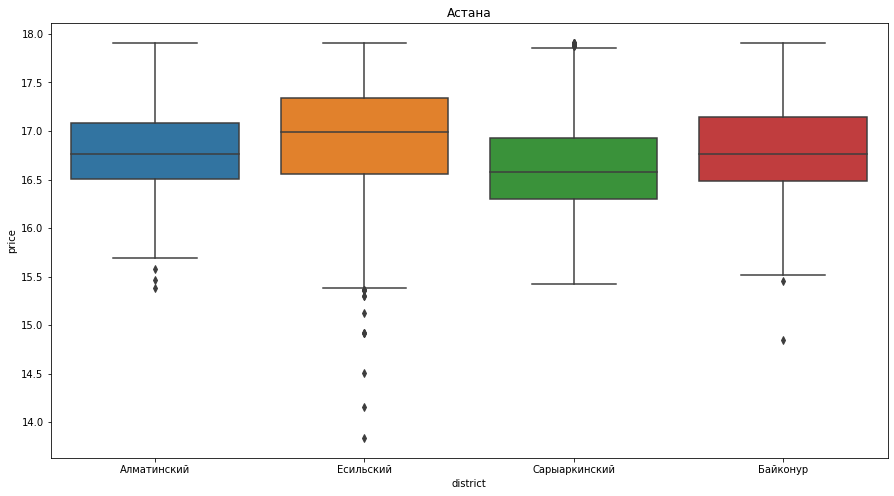

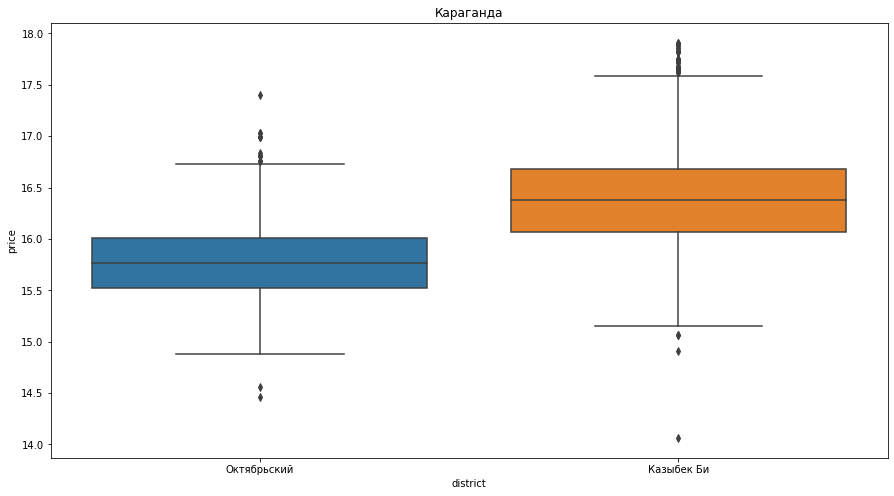

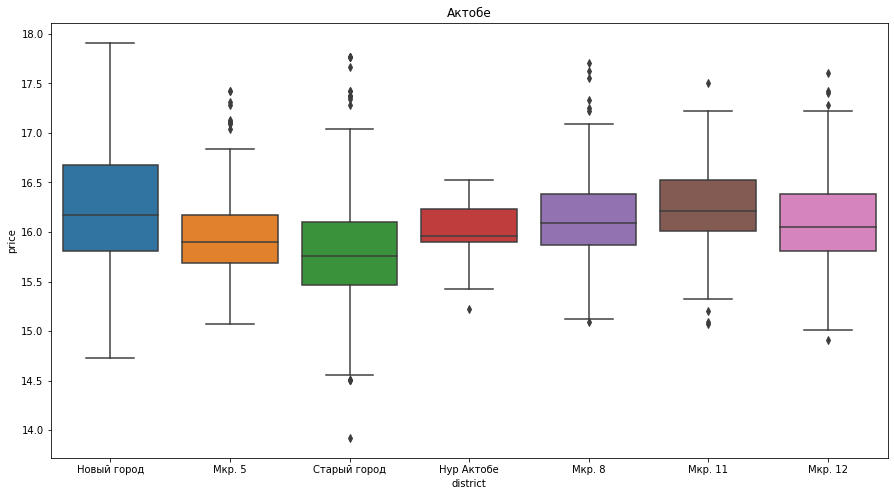

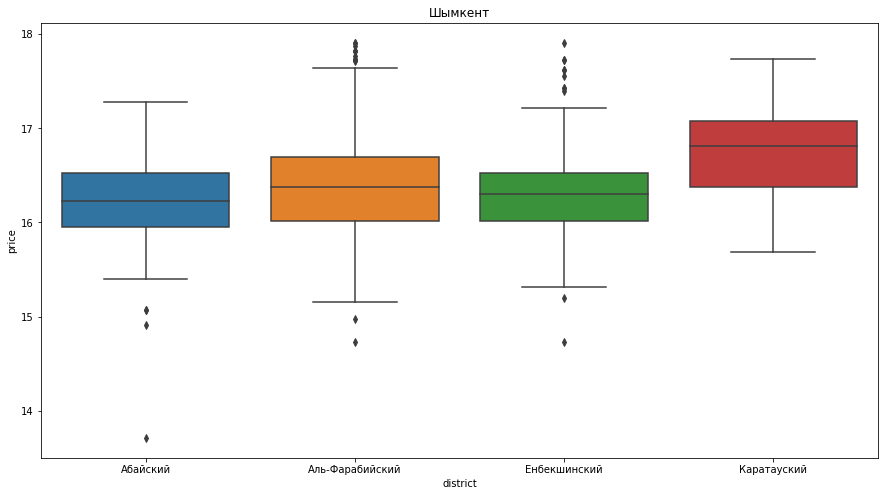

In [45]:
# Looking at the relationships between price and districts (for cities where district is specified)
cities = data['city'].value_counts().index
for i, city in enumerate(cities):
    city_data = data[data['city'] == city]
    districts = city_data['district'].value_counts().index
    if len(districts):
        plt.figure(i, figsize=(15,8))
        plt.title(city)
        sns.boxplot(x='district', y='price', data=city_data)

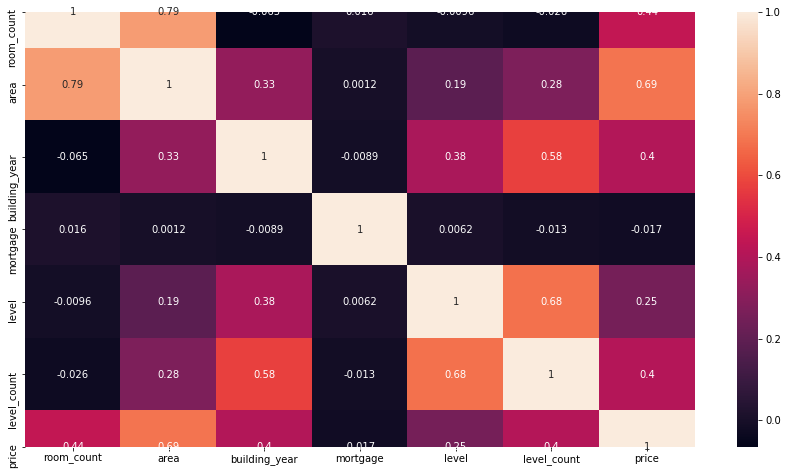

In [46]:
corr = data.corr()
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)

There aren't a lot of highly correlated dependent variables. Looks like **mortgage** and **level** have lowest correlation with **price**.

Also, **room_count** and **area** have some correlation with **price**, but are correlated with each other, so we'll choose **area** for further modeling.

## Data Preparation

In [47]:
# Building a model for cities without districts first
cities_nd = data[data['district'].isnull()]['city'].value_counts().index
cities_d = data[data['district'].notnull()]['city'].value_counts().index

# no districts
X_nd = data[data['district'].isnull()].drop(columns=['price', 'city', 'room_count', 'building_year', 'mortgage', 'level', 'district', 'title', 'street'])
y_nd = data[data['district'].isnull()]['price']

# with districts
X_d = data[data['district'].notnull()].drop(columns=['price', 'city', 'room_count', 'building_year', 'mortgage', 'level', 'title', 'street'])
y_d = data[data['district'].notnull()]['price']

In [36]:
# data.to_csv("clean.csv", index=False)

In [37]:
# clean = pd.read_csv("clean.csv")

In [48]:
# Building a model for different cities
city = 'Астана'
X = X_d[data['city'] == city]
y = y_d[data['city'] == city]
X.shape

/Users/Kairat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


(15597, 6)

In [49]:
def get_processed_data(df):
    # getting categorical columns
    categorical = df.select_dtypes(include=['object'])
    
    # transforming into dummies
    cat_dummies = pd.get_dummies(categorical, drop_first=True)
    
    # getting numerical columns
    df = df.drop(columns=categorical)
    
    # merging numerical with categorical dummies
    df_X = pd.merge(df, cat_dummies, on=df.index)
    df_X.drop(columns='key_0', inplace=True)
    df_X.index = df.index
    
    return df_X

In [50]:
X = get_processed_data(X)
X.head()

,area,level_count,building_type_каркасно-камышитовый,building_type_кирпичный,building_type_монолитный,building_type_панельный,condition_свободная планировка,condition_среднее,condition_требует ремонта,condition_хорошее,condition_черновая отделка,district_Байконур,district_Есильский,district_Сарыаркинский,building_new_1
4,4.584967,7,0,0,1,0,0,0,0,0,1,0,0,0,1
8,3.610918,14,0,1,0,0,0,0,0,0,0,0,1,0,1
9,4.174387,9,0,1,0,0,0,0,0,0,0,0,0,1,1
10,4.317488,9,0,1,0,0,0,0,0,0,0,0,1,0,1
18,4.110874,19,0,0,1,0,0,0,0,0,1,0,1,0,1


In [51]:
# Scaling the features

from sklearn.preprocessing import scale

cols = X.columns
X_scaled = pd.DataFrame(scale(X), index=X.index)
X_scaled.columns = cols
X_scaled.head()

,area,level_count,building_type_каркасно-камышитовый,building_type_кирпичный,building_type_монолитный,building_type_панельный,condition_свободная планировка,condition_среднее,condition_требует ремонта,condition_хорошее,condition_черновая отделка,district_Байконур,district_Есильский,district_Сарыаркинский,building_new_1
4,1.072925,-0.726725,-0.01387,-0.977869,1.185677,-0.295043,-0.078283,-0.247169,-0.131469,-0.780235,2.459248,-0.287008,-0.842398,-0.447988,0.38605
8,-1.292366,0.604066,-0.01387,1.022632,-0.843400,-0.295043,-0.078283,-0.247169,-0.131469,-0.780235,-0.406628,-0.287008,1.187087,-0.447988,0.38605
9,0.075911,-0.346499,-0.01387,1.022632,-0.843400,-0.295043,-0.078283,-0.247169,-0.131469,-0.780235,-0.406628,-0.287008,-0.842398,2.232205,0.38605
10,0.423403,-0.346499,-0.01387,1.022632,-0.843400,-0.295043,-0.078283,-0.247169,-0.131469,-0.780235,-0.406628,-0.287008,1.187087,-0.447988,0.38605
18,-0.078319,1.554632,-0.01387,-0.977869,1.185677,-0.295043,-0.078283,-0.247169,-0.131469,-0.780235,2.459248,-0.287008,1.187087,-0.447988,0.38605


In [52]:
X_scaled.describe()

,area,level_count,building_type_каркасно-камышитовый,building_type_кирпичный,building_type_монолитный,building_type_панельный,condition_свободная планировка,condition_среднее,condition_требует ремонта,condition_хорошее,condition_черновая отделка,district_Байконур,district_Есильский,district_Сарыаркинский,building_new_1
count,1.559700e+04,1.559700e+04,1.559700e+04,1.559700e+04,1.559700e+04,1.559700e+04,1.559700e+04,1.559700e+04,1.559700e+04,1.559700e+04,1.559700e+04,1.559700e+04,1.559700e+04,1.559700e+04,1.559700e+04
mean,1.088788e-15,-4.050431e-15,7.413712e-16,7.914708e-16,3.229691e-15,-2.818032e-15,6.550206e-16,6.054798e-16,-3.627512e-15,6.821440e-15,7.452830e-15,1.111326e-15,2.791737e-15,1.355800e-16,-2.980141e-15
std,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00,1.000032e+00
min,-2.244364e+00,-1.867403e+00,-1.387017e-02,-9.778687e-01,-8.433998e-01,-2.950431e-01,-7.828309e-02,-2.471692e-01,-1.314691e-01,-7.802355e-01,-4.066284e-01,-2.870076e-01,-8.423984e-01,-4.479875e-01,-2.590335e+00
25%,-8.170379e-01,-7.267251e-01,-1.387017e-02,-9.778687e-01,-8.433998e-01,-2.950431e-01,-7.828309e-02,-2.471692e-01,-1.314691e-01,-7.802355e-01,-4.066284e-01,-2.870076e-01,-8.423984e-01,-4.479875e-01,3.860504e-01
50%,1.988719e-05,-3.464989e-01,-1.387017e-02,-9.778687e-01,-8.433998e-01,-2.950431e-01,-7.828309e-02,-2.471692e-01,-1.314691e-01,-7.802355e-01,-4.066284e-01,-2.870076e-01,-8.423984e-01,-4.479875e-01,3.860504e-01
75%,7.273379e-01,6.040664e-01,-1.387017e-02,1.022632e+00,1.185677e+00,-2.950431e-01,-7.828309e-02,-2.471692e-01,-1.314691e-01,1.281664e+00,-4.066284e-01,-2.870076e-01,1.187087e+00,-4.479875e-01,3.860504e-01
max,3.740693e+00,5.547006e+00,7.209716e+01,1.022632e+00,1.185677e+00,3.389335e+00,1.277415e+01,4.045812e+00,7.606353e+00,1.281664e+00,2.459248e+00,3.484229e+00,1.187087e+00,2.232205e+00,3.860504e-01


## Model Building

In [68]:
# Splitting data into training and testing sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.7, test_size=0.3)

In [69]:
# Building a rough Linear Regression model

from sklearn import linear_model
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)

y_pred_test = lm.predict(X_test)
y_pred_train = lm.predict(X_train)

In [70]:
# Checking R2 & RMSE scores of the model for training and testing sets

from sklearn.metrics import r2_score

print('R-square on train data: {}'.format(r2_score(y_true=y_train, y_pred=y_pred_train)))
print('R-square on test data: {}'.format(r2_score(y_true=y_test, y_pred=y_pred_test)))

error_train = y_pred_train - y_train
error_test = y_pred_test - y_test

print('RMSE on train data: {}'.format(((error_train**2).mean())**0.5))
print('RMSE on test data: {}'.format(((error_test**2).mean())**0.5))

R-square on train data: 0.8503789630480492
R-square on test data: 0.8304366977577219
RMSE on train data: 0.1855729897586991
RMSE on test data: 0.19699649895893326


## Feature Selection

In [71]:
# Checking the model for different number of params

from sklearn.feature_selection import RFE
import statsmodels.api as sm

min_features = 4
max_features = 16
n_features_list = list(range(min_features, max_features))

train_adjusted_r2 = []
train_r2 = []
test_r2 = []
train_RMSE = []
test_RMSE = []

for n_features in range(min_features, max_features):
    
    # RFE with n features
    lm = LinearRegression()
    
    # specifying number of features
    rfe_n = RFE(estimator=lm, n_features_to_select=n_features)
    
    # fit with n features
    rfe_n.fit(X_train, y_train)
    
    #selecting features selected by rfe_n
    col_n = X_train.columns[rfe_n.support_]
    
    #training & testing data for n selected columns
    X_train_rfe_n = X_train[col_n]
    X_test_rfe_n = X_test[col_n]
    
    # add a constant to the model
    X_train_rfe_n = sm.add_constant(X_train_rfe_n, has_constant='add')
    X_test_rfe_n = sm.add_constant(X_test_rfe_n, has_constant='add')
    
    # fitting the model with n features
    lm_n = sm.OLS(y_train, X_train_rfe_n).fit()
    
    # Making predictions
    y_pred_test = lm_n.predict(X_test_rfe_n)
    y_pred_train = lm_n.predict(X_train_rfe_n)
    
    # Calculating evaluation metrics
    
    # R-square
    train_adjusted_r2.append(lm_n.rsquared_adj)
    train_r2.append(lm_n.rsquared)
    test_r2.append(r2_score(y_test, y_pred_test))
    
    # RMSE / stand. error
    error_test = y_pred_test - y_test
    error_train = y_pred_train - y_train
    
    test_RMSE.append(((error_test**2).mean())**0.5)
    train_RMSE.append(((error_train**2).mean())**0.5)

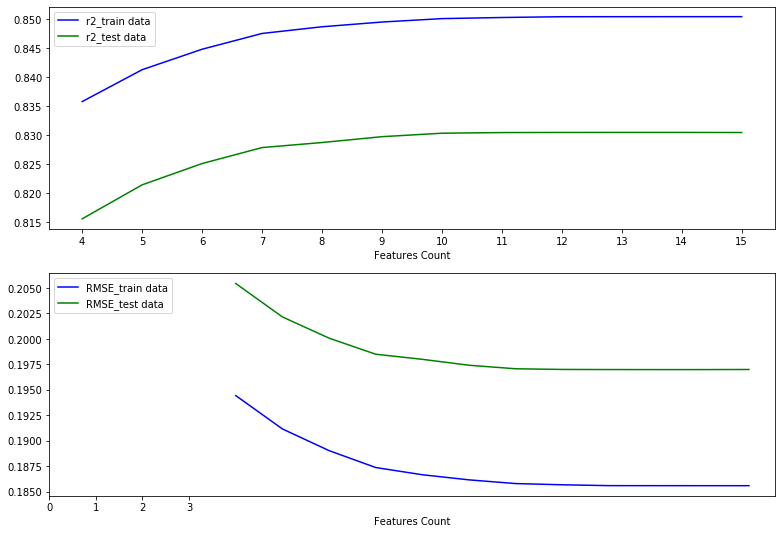

In [72]:
# Visualizing R2 and RMSE scores for models with 4-16 params

import matplotlib.ticker as plticker

fig,ax=plt.subplots(2,1,figsize=(13, 9))
ax[0].plot(n_features_list, train_r2,'b', label="r2_train data")
ax[0].plot(n_features_list, test_r2,'g', label="r2_test data")
ax[0].set_xlabel('Features Count')

ax[0].legend(loc='upper left')
loc = plticker.MultipleLocator(base=1)
ax[0].xaxis.set_major_locator(loc) #method 1 of ticks

ax[1].plot(n_features_list, train_RMSE, 'b',label="RMSE_train data")
ax[1].plot(n_features_list, test_RMSE, 'g',label="RMSE_test data")
ax[1].set_xlabel('Features Count')


ax[1].legend(loc='upper left')
plt.xticks(np.arange(0, min_features, step=1))#method 2 of ticks

plt.show()

Text(0.5, 0, 'Index')

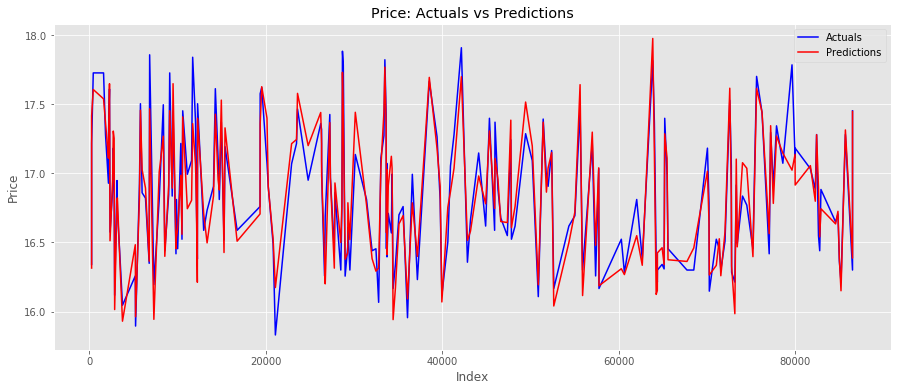

In [73]:
# Visualizing the actual and predicted values (taking subset, so the graph isn't cluttered)
start = 0
end = 200
yy_test = y_test[start:end]
yy_pred_test = y_pred_test[start:end]

plt.style.use('ggplot')
fig, ax=plt.subplots(figsize=(15,6))
sns.lineplot(x=yy_test.index,y=yy_test,label='Actuals',color='blue',ax=ax)
sns.lineplot(x=yy_pred_test.index,y=yy_pred_test,label='Predictions',color='red',ax=ax)
ax.set_title('Price: Actuals vs Predictions')
ax.set_ylabel('Price')
ax.set_xlabel('Index')

In [74]:
# Looks like models with 11 to 15 params have better performance
# Leaving in all the params that we had initially, so we don't have to deal with removing features

X_train_const = sm.add_constant(X_train, has_constant='add')
X_test_const = sm.add_constant(X_test, has_constant='add')

lm_sm = sm.OLS(y_train, X_train_const).fit()

y_pred_train = lm_sm.predict(X_train_const)
y_pred_test = lm_sm.predict(X_test_const)

train_r2 = lm_sm.rsquared
test_r2 = r2_score(y_pred_test, y_test)

error_test = y_pred_test - y_test
error_train = y_pred_train - y_train

test_RMSE = (((error_test**2).mean())**0.5)
train_RMSE = (((error_train**2).mean())**0.5)

print('----------------------R-square-------------------------------------------')
print("R-sq for test data is {}".format(test_r2))
print("R-sq for train data is {}".format(train_r2))


print('----------------------STANDARD ERROR/RMSE-------------------------------------------')
print("RMSE for test data is {}".format(test_RMSE))
print("RMSE for train data is {}".format(train_RMSE))

print(lm_sm.summary())

----------------------R-square-------------------------------------------
R-sq for test data is 0.7947259178765815
R-sq for train data is 0.8503789630480492
----------------------STANDARD ERROR/RMSE-------------------------------------------
RMSE for test data is 0.1969964989589333
RMSE for train data is 0.1855729897586989
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     4130.
Date:                Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                        17:33:38   Log-Likelihood:                 2897.0
No. Observations:               10917   AIC:                            -5762.
Df Residuals:                   10901   BIC:                            -5645.
Df Model:                          15      

Text(0.5, 0, 'Index')

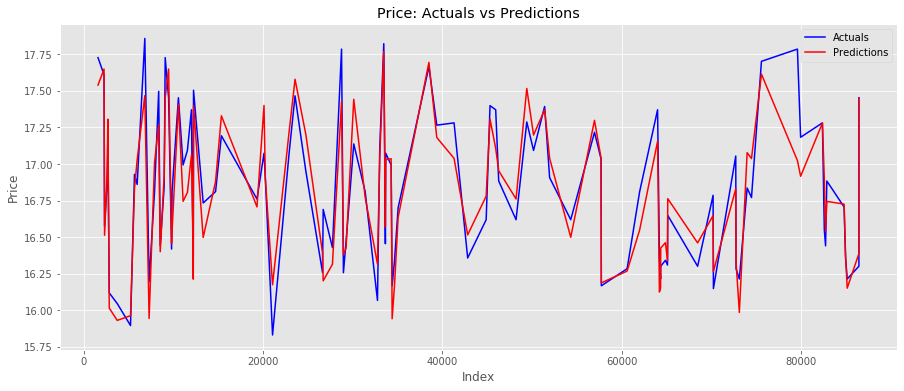

In [75]:
# Visualizing actual vs predicted

start = 0
end = 100
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x=y_test.index[start:end], y=y_test[start:end], label='Actuals', color='blue', ax=ax)
sns.lineplot(x=y_test.index[start:end], y=y_pred_test[start:end], label='Predictions', color='red', ax=ax)
ax.set_title('Price: Actuals vs Predictions')
ax.set_ylabel('Price')
ax.set_xlabel('Index')

## Assumption Validation and Outlier Removal

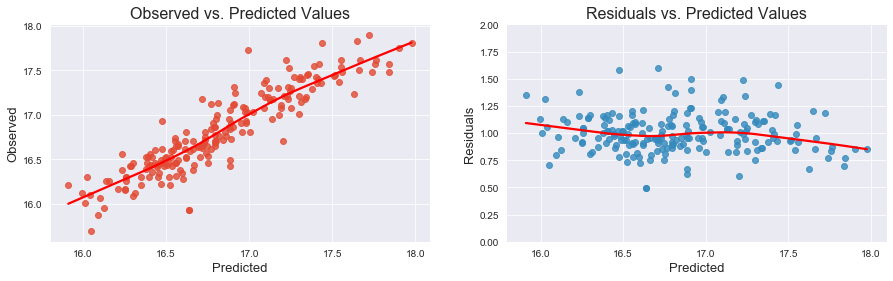

In [76]:
# Visualing the residuals (taking a set of 200 random points for better view)
def linearity_test(model, y):
    fitted_vals = model.predict()
    residuals = model.resid
    residuals = residuals.reset_index(drop=True)
    residuals = np.exp(residuals)
    actual = y.reset_index(drop=True)
    
    rand_index = np.random.randint(0, fitted_vals.shape[0], size=200)
    
    sns.set_style('darkgrid')
    fig,ax=plt.subplots(1,2, figsize=(15,4))
    
    sns.regplot(x=fitted_vals[rand_index], y=actual[rand_index], lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set_xlabel('Predicted', fontsize=13)
    ax[0].set_ylabel('Observed', fontsize=13)
    
    sns.regplot(x=fitted_vals[rand_index],y=residuals[rand_index],lowess=True,ax=ax[1],line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set_xlabel('Predicted', fontsize=13)
    ax[1].set_ylabel('Residuals', fontsize=13)
    ax[1].set_ybound(0, 2)
    
linearity_test(lm_sm, y_train)

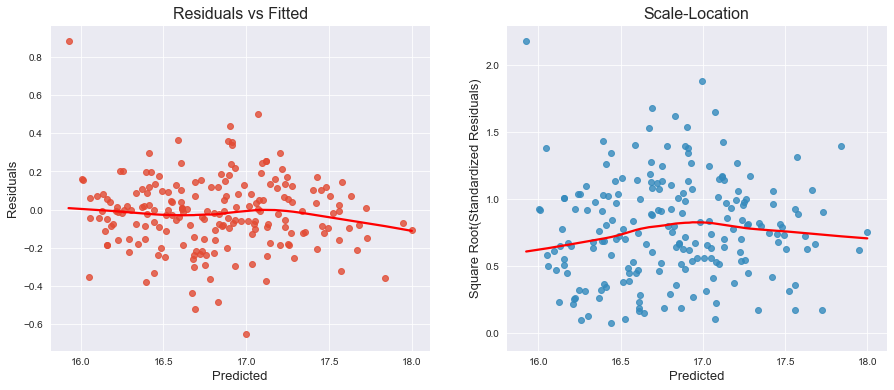

In [77]:
# Checking the model for homescedasticity

import statsmodels.stats.api as sms

def homoscedasticity_test(model):
    fitted_vals = model.predict()
    residuals = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    residuals = residuals.reset_index(drop=True)
    sns.set_style('darkgrid')
    
    rand_index = np.random.randint(0, fitted_vals.shape[0], size=200)
    
    fig, ax = plt.subplots(1, 2, figsize=(15,6))
    
    sns.regplot(x=fitted_vals[rand_index], y=residuals[rand_index], lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set_xlabel('Predicted', fontsize=13)
    ax[0].set_ylabel('Residuals', fontsize=13)
    
    sns.regplot(x=fitted_vals[rand_index], y=np.sqrt(np.abs(resids_standardized))[rand_index], lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set_xlabel('Predicted', fontsize=13)
    ax[1].set_ylabel('Square Root(Standardized Residuals)', fontsize=13)
    
homoscedasticity_test(lm_sm)

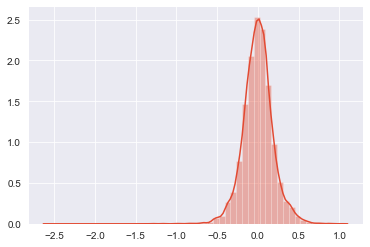

In [78]:
# Looks like the points are scattered evenly, without any noticeable pattern.
# Let's check the distribution of the residuals.
sns.distplot(lm_sm.resid)

/Users/Kairat/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Jarque-Bera test ---- statistic: 12858.6788, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.9732, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.3356, p-value: 0.0000
Anderson-Darling test ---- statistic: 38.5451, 5% critical value: 0.7870
If the returned Anderson-Darling statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


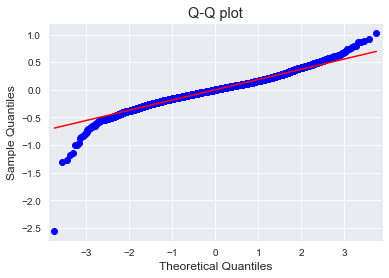

In [79]:
# The residuals distribution looks Normal.
# Visualizing normality with a Q-Q plot.
from scipy import stats

def normality_of_residuals_test(model):
    
    sm.ProbPlot(model.resid).qqplot(line='s')
    plt.title('Q-Q plot')
    
    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    
    print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
    print('If the returned Anderson-Darling statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')
    
normality_of_residuals_test(lm_sm)

We clearly see that the points lie on the line for the most part, but they noticeably diverge from the line in the tails.

Though the residuals distribution looks bell-shaped, the divergence might be related to the short tails of the distribution.

In [80]:
def influential_outliers_test(model, top_influencing_obs_count):
    influence = model.get_influence()
    
    leverage = influence.hat_matrix_diag
    
    cooks_d = influence.cooks_distance
    
    standardized_residuals = influence.resid_studentized_internal
    
    studentized_residuals = influence.resid_studentized_external
    
    plot_lm = plt.figure(figsize=(15,5))
    plt.scatter(leverage, standardized_residuals, alpha=0.5)
    sns.regplot(leverage, standardized_residuals, scatter=False, ci=False, lowess=True, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plot_lm.axes[0].set_xlim(0, max(leverage)+0.01)
    #plot_lm.axes[0].set_ylim(-10, 20)
    plot_lm.axes[0].set_title('Standardized Residuals vs Leverage', fontsize=16)
    plot_lm.axes[0].set_xlabel('Leverage', fontsize=13)
    plot_lm.axes[0].set_ylabel('Standardized Residuals', fontsize=13)
    
    leverage_top_n_obs = np.flip(np.argsort(cooks_d[0]), 0)[:top_influencing_obs_count]
    print("Top-10 influential points: ", leverage_top_n_obs)
    
    for i in leverage_top_n_obs:
        plot_lm.axes[0].annotate(i, xy=(leverage[i], studentized_residuals[i]))
        
    def graph(formula, x_range, label=None):
        x = x_range
        y = formula(x)
        plt.plot(x, y, label=label, lw=1, ls='--', color='blue')

    p = len(lm_sm.params)

    graph(lambda x: np.sqrt((0.5 * p * (1-x)) / x), np.linspace(0.001, max(leverage), 50), 'Cook\'s distance')
    plt.legend(loc='upper right')

Top-10 influential points:  [ 3902  7095   493  4008  5408 10613  3319  9506  7512  9118]


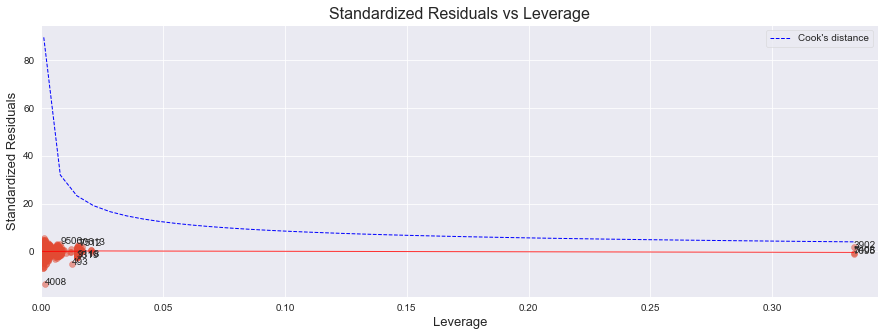

In [81]:
influential_outliers_test(model=lm_sm, top_influencing_obs_count=10)

In [82]:
# Building the final model without influential outliers
outlier_idx = X_train.iloc[[3902, 7095, 493, 4008, 5408]].index
outlier = X_train.index.isin(outlier_idx)

X_train_no_outliers = X_train[~outlier]
y_train_no_outliers = y_train[~outlier]


lm = LinearRegression()

rfe = RFE(estimator=lm, n_features_to_select=12)

rfe.fit(X_train_no_outliers, y_train_no_outliers)

col= X_train_no_outliers.columns[rfe.support_] 

X_final=X_train_no_outliers[col] #X DF wuith top 6 features only

X_final= sm.add_constant(X_final,has_constant='add')

lm_sm=sm.OLS(y_train_no_outliers,X_final).fit()

print(lm_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     5265.
Date:                Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                        17:47:59   Log-Likelihood:                 3005.3
No. Observations:               10912   AIC:                            -5985.
Df Residuals:                   10899   BIC:                            -5890.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

## Multicollinearity Check

In [83]:
# No obvious outliers detected
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

def variance_inflation_factors(X_df):
    X_df = add_constant(X_df)
    vifs = pd.Series([1 / (1. - OLS(X_df[col].values, 
                       X_df.loc[:, X_df.columns != col].values).fit().rsquared) 
         for col in X_df],
        index=X_df.columns,
        name='VIF'
    )
    return vifs

In [84]:
variance_inflation_factors(X_train)

const                                  1.000316
area                                   1.073697
level_count                            1.542571
building_type_каркасно-камышитовый     1.017936
building_type_кирпичный               16.475309
building_type_монолитный              16.144080
building_type_панельный                6.112378
condition_свободная планировка         1.012709
condition_среднее                      1.131634
condition_требует ремонта              1.035474
condition_хорошее                      1.307429
condition_черновая отделка             1.214001
district_Байконур                      1.145603
district_Есильский                     1.503300
district_Сарыаркинский                 1.277853
building_new_1                         2.156674
Name: VIF, dtype: float64

No collinear params are detected.
We can ignore the high VIF of the categorical variables.